# Special Thanks to Mike Cohen

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_11972/1319117283.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
import torchvision
import pandas as pd

# Load the MNIST dataset (train and test sets)
mnist_train = torchvision.datasets.MNIST(root='.', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='.', train=False, download=True)

# Extract the training and testing data and labels
train_data = mnist_train.data.numpy()
train_labels = mnist_train.targets.numpy()
test_data = mnist_test.data.numpy()
test_labels = mnist_test.targets.numpy()

# Flatten the data
train_data_flat = train_data.reshape(train_data.shape[0], -1)
test_data_flat = test_data.reshape(test_data.shape[0], -1)

# Create DataFrames from the flattened data
train_df = pd.DataFrame(train_data_flat)
test_df = pd.DataFrame(test_data_flat)

# Insert the label column as the first column
train_df.insert(0, 'label', train_labels)
test_df.insert(0, 'label', test_labels)

# Save the dataframes to CSV files without the index
train_df.to_csv('train_mnist.csv', index=False)
test_df.to_csv('test_mnist.csv', index=False)


# Import and process the data

In [3]:
data = np.loadtxt(open('train_mnist.csv','rb'),delimiter=',',skiprows=1)

# don't need labels!
data = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

# Create the DL model

- **Model Architecture Definition**: Initializes an autoencoder (`aenet`) specifically structured for the MNIST dataset. The model architecture consists of input, encoder, latent, and decoder layers that transform the input data into a compressed representation and attempt to reconstruct it.

- **Activation Functions**: Employs ReLU activation functions for the input, encoder, and latent layers to introduce non-linear transformations, enhancing the model's learning capability. The decoder's output applies the sigmoid function to ensure the final reconstruction values range between 0 and 1.

- **Training Components**: Creates a model instance along with defining a loss function (`nn.MSELoss()`) to measure reconstruction accuracy, and an Adam optimizer to iteratively improve model parameters, with a set learning rate of 0.001 for the training process.


In [4]:
# create a class for the model
def createTheMNISTAE():

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,128)
      
      ### encoder layer
      self.enc = nn.Linear(128,50)

      ### latent layer
      self.lat = nn.Linear(50,128)

      ### decoder layer
      self.dec = nn.Linear(128,784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) )
      return y
  
  # create the model instance
  net = aenet()
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

- **Model Initialization**: Calls the `createTheMNISTAE` function to create an instance of the autoencoder (`net`), along with the loss function (`lossfun`) and optimizer (`optimizer`) required for training.

- **Data Preparation**: Selects the first five samples from the preprocessed MNIST dataset (`dataT`) for testing the model. This small subset is used to quickly verify the dimensions and output of the model.

- **Model Inference**: Passes the selected samples (`X`) through the autoencoder to obtain the reconstructed outputs (`yHat`). The shapes of the original input data and the reconstructed data are printed to confirm the model is operating correctly, with the output shape matching the input shape.


In [5]:
# test the model with a bit of data
net,lossfun,optimizer = createTheMNISTAE()

X = dataT[:5,:]
yHat = net(X)

print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


- **Visualization Setup**: Initializes a plot with two rows and five columns using `plt.subplots`. The figure size is set to 10x3 inches for clarity.

- **Displaying Original Images**: The first row of the plot displays the original images from the MNIST dataset. Each image is reshaped back into 28x28 pixels and detached from the current computation graph for visualization purposes.

- **Displaying Reconstructed Images**: The second row shows the corresponding reconstructed images output by the autoencoder. Similarly, these are reshaped into 28x28 pixels and detached.

- **Axis Adjustments**: Axes ticks are removed for both rows to ensure that the images are the focus of the visualization.

- **Plot Title and Display**: A title 'Yikes!!!' is added to the plot, which may suggest that the reconstructions are not as expected. Finally, `plt.show()` is called to render the plot.


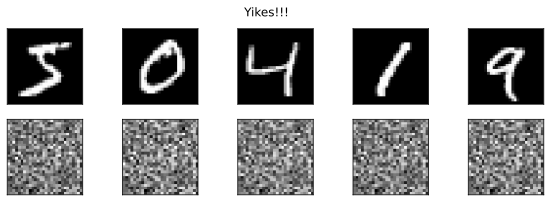

In [6]:
# let's see what the model did!
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(yHat[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  
plt.suptitle('Yikes!!!')
plt.show()

# Create a function that trains the model

The `function2trainTheModel` is designed to train the autoencoder model defined by the `createTheMNISTAE` function. Here's a breakdown of its components and the training process:

- **Epochs**: Sets the training duration to 10,000 epochs, allowing the model sufficient time to learn from the data through repeated exposure.

- **Model Initialization**: Invokes `createTheMNISTAE` to instantiate a new model (`net`), along with its corresponding loss function (`lossfun`) and optimizer (`optimizer`). This setup is ready for the training phase.

- **Loss Tracking**: Initializes a tensor `losses` to record the loss value at each epoch, facilitating the monitoring of the model's performance improvement over time.

- **Training Loop**: Iterates over the specified number of epochs, randomly selecting a batch of 32 images from the preprocessed MNIST dataset (`dataT`) for each training iteration.

  - **Forward Pass**: Computes the model's predictions (`yHat`) for the selected batch and calculates the loss by comparing the predictions against the actual images using `lossfun`.

  - **Backpropagation and Optimization**: Performs backpropagation to compute the gradients of the loss with respect to the model parameters, then updates these parameters using the `optimizer` to minimize the loss.

- **Epoch Loss Recording**: Stores the loss value of each epoch in the `losses` tensor, providing a record of how the model's performance evolves as training progresses.

- **Function Output**: Returns the `losses` tensor, which contains the loss values across all epochs, and the trained model (`net`). This output can be used for further analysis or for applying the model to new data.


In [7]:
def function2trainTheModel():

  # number of epochs
  numepochs = 10000
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTAE()

  # initialize losses
  losses = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # select a random set of images
    randomidx = np.random.choice(dataT.shape[0],size=32)
    X = dataT[randomidx,:]

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,X)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # losses in this epoch
    losses[epochi] = loss.item()
  # end epochs

  # function output
  return losses,net

# Run the model and show the results!

Final loss: 0.0076


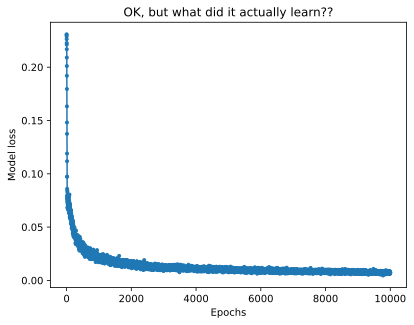

In [8]:
# train the model (90s)
losses,net = function2trainTheModel()
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('OK, but what did it actually learn??')
plt.show()

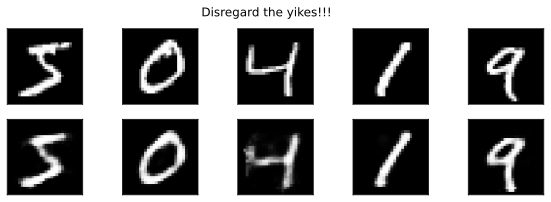

In [9]:
# Repeat the visualization when testing the model
X = dataT[:5,:]
yHat = net(X)


# let's see what the model did!
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(yHat[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  
plt.suptitle('Disregard the yikes!!!')
plt.show()

# Add noise to see a use case of an autoencoder

- **Image Selection**: A subset of 10 images is extracted from the preprocessed MNIST dataset (`dataT`) for manipulation and visualization.

- **Noise Addition**: Random noise is added to the selected images (`X`) to simulate conditions of imperfect image capture. This noise is scaled down to ensure it doesn't overwhelm the original image content.

- **Clipping**: The noisy images are clipped to ensure pixel values do not exceed 1, maintaining the validity of the image data for visualization and further processing.

- **Visualization**: Displays the original and noisy versions of the first 5 images in a 2x5 subplot grid, illustrating the effect of the added noise. This visual comparison helps in understanding the robustness of models against input data variations.


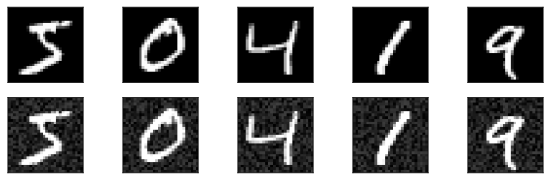

In [10]:
# grab a small set of images
X = dataT[:10,:]

# add noise
Xnoise = X + torch.rand_like(X)/4

# clip at 1
Xnoise[Xnoise>1] = 1


# show the noisy images
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  
plt.show()

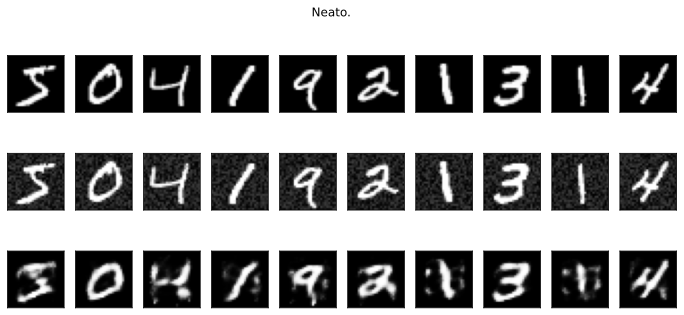

In [11]:
# run through the model
Y = net(Xnoise)


# show the noisy images
fig,axs = plt.subplots(3,10,figsize=(12,5))

for i in range(10):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].imshow(Y[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])
  
plt.suptitle('Neato.')
plt.show()